In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import h5py
import math as ma
from astropy.io import fits
from astropy.time import Time
from matplotlib import pyplot as plt
from matplotlib.axis import Axis
from pyuvdata import UVData
import matplotlib as mpl

In [ ]:
df = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/observation_id/observation_id.csv", header=0, engine='python')
df['date'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z").date())
df['date_time'] = df.starttime_utc.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.000Z"))
df['partition'] = pd.factorize(df['date'])[0] + 1
df = df[df['partition'] == 1].reset_index(drop=True)

---

#### Checking the results normal vs faster algorithm

In [ ]:
df_sel_rfi_fast = pd.DataFrame()
transform_tb = np.repeat(np.arange(0,14,1), 4)

for n in range(1):
    #with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
    with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
        data = f["wins_z_score"][:]
        obs_id = f["obs_id"][:]
        time_blocks = f["time_blocks"][:]

    flat_data = data.reshape(-1, data.shape[-1])
    
    # Create DataFrame
    df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
    df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
    df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
    df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
    df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
    df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))
    #df_temp['timeblock'] = df_temp.timeblock.apply(lambda x: np.where(transform_tb == x)[0].tolist())
    #df_temp = df_temp.explode('timeblock').reset_index(drop=True)

    df_sel_rfi_fast = pd.concat([df_sel_rfi_fast, df_temp]).reset_index(drop = True)


In [ ]:
df_sel_rfi_slow = pd.DataFrame()
for o in range(1):
    #aa = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/both_side_selected_outliers_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    aa = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/observation_data/both_side_selected_outliers_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    aa.columns = ['xx', 'yy', 'obs_id', 'timeblocks', 'tile', 'freqs', 'z_score', 'polarization']
    aa = aa[~aa['z_score'].isna()].reset_index(drop=True)
    aa['z_score'] = aa['z_score'].astype(float)
    aa['floor_z_score'] = aa['z_score'].apply(lambda x: ma.floor(x))
    df_sel_rfi_slow = pd.concat([df_sel_rfi_slow, aa]).reset_index(drop = True)

In [ ]:
np.unique(df_sel_rfi_fast['obs_id'])

In [ ]:
df_sel_rfi_fast[df_sel_rfi_fast['obs_id'] == 1095450824].head(10)

In [ ]:
df_sel_rfi_slow[(df_sel_rfi_slow['obs_id'] == 1095450824) & (df_sel_rfi_slow['freqs'] == 0) & (df_sel_rfi_slow['tile'] == 0) & (df_sel_rfi_slow['timeblocks'] == 0)]

---

#### Min max comparison

In [ ]:
df_stat_slow = pd.DataFrame()
for o in range(1):
    #oo = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/both_side_outliers_statistics_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    oo = pd.read_csv("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/slower/observation_data/both_side_outliers_statistics_3_sigma_day_1_grid_[%s]_iter_100_real_part_8s.csv" %(o), header=None)
    oo.columns = ['tile', 'freqs', 'polarization', 'skewness', 'max', 'min', 'mean', 'win_mean', 'std', 'win_std', 'gamma_final', 'number_of_outliers']
    oo['grid'] = o
    df_stat_slow = pd.concat([df_stat_slow, oo]).reset_index(drop = True)

In [ ]:
df_stat_fast = pd.DataFrame()
for o in range(1):
    #oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/outlier_statistics_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/outlier_statistics_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo['grid'] = o
    df_stat_fast = pd.concat([df_stat_fast, oo]).reset_index(drop = True)

In [ ]:
df_gamma_fast = pd.DataFrame()
for o in range(1):
    #oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/test/results/faster/final_gamma_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo = pd.read_parquet("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/final_gamma_day_1_grid_%s_integration_8_real.parquet" %(o))
    oo['grid'] = o
    df_gamma_fast = pd.concat([df_gamma_fast, oo]).reset_index(drop = True)

In [ ]:
df_stat_slow[(df_stat_slow['tile'] == 6) & (df_stat_slow['freqs'] == 100)]

In [ ]:
df_stat_fast[(df_stat_fast['antenna'] == 6) & (df_stat_fast['frequency'] == 100) & (df_stat_fast['polarization'].isin([0,3]))]

In [ ]:
df_gamma_fast[(df_gamma_fast['antenna'] == 6) & (df_gamma_fast['frequency'] == 100) & (df_stat_fast['polarization'].isin([0,3]))]

---

In [ ]:
df_sel_rfi_fast = pd.DataFrame()
transform_tb = np.repeat(np.arange(0,14,1), 4)

for n in range(1):
    with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/win_z_scores_data_day_1_grid_%s_integration_8_real.h5' %(n), "r") as f:
        data = f["wins_z_score"][:]
        obs_id = f["obs_id"][:]
        time_blocks = f["time_blocks"][:]

    flat_data = data.reshape(-1, data.shape[-1])
    
    # Create DataFrame
    df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
    df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
    df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
    df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
    df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
    df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))
    #df_temp['timeblock'] = df_temp.timeblock.apply(lambda x: np.where(transform_tb == x)[0].tolist())
    #df_temp = df_temp.explode('timeblock').reset_index(drop=True)

    df_sel_rfi_fast = pd.concat([df_sel_rfi_fast, df_temp]).reset_index(drop = True)


In [ ]:
df_sel_rfi_fast[df_sel_rfi_fast['time_index'] == 0]

In [ ]:
f = fits.open(f"/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/calibration_solutions/20250712_observation_data_8s_before_with_cotter_time_corrections_without_flags/uvfits/calibrated_fits/hyperdrive_solutions_1095450704.fits")

In [ ]:
f['SOLUTIONS'].data[:, :, :, ::2]

In [ ]:
g = fits.open(f"/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/calibration_solutions/20240831_multiple_simulation_higher_thermal_noise_sn3_8s/uvfits/calibrated_fits/hyperdrive_solutions_1095450704.fits")

In [ ]:
g['SOLUTIONS'].data[:, :, :, ::2]

---

#### Importing h5 file for flagging

In [5]:
with h5py.File('/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/outliers_location_day_1_grid_%s_integration_8_real.h5' %(0), "r") as f:
    data = f["outliers_mask"][:]
    obs_id = f["obs_id"][:]
    time_blocks = f["time_blocks"][:]

In [6]:
flat_data = data.reshape(-1, data.shape[-1])
    
# Create DataFrame
df_temp = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

df_temp["obs_id"] = np.tile(obs_id, data.shape[1]*data.shape[2])
df_temp["time_index"] = np.repeat(np.arange(data.shape[0]), data.shape[1] * data.shape[2])
df_temp["frequency"] = np.tile(np.arange(data.shape[2]), data.shape[0] * data.shape[1])
df_temp["antenna"] = np.tile(np.repeat(np.arange(data.shape[1]), data.shape[2]), data.shape[0])
df_temp["obs_id"] = df_temp['time_index'].map(lambda t: obs_id[t])
df_temp["timeblock"] = df_temp['time_index'].map(lambda t: int(time_blocks[t]))

In [9]:
dfs = df_temp[(df_temp['XX'] == True) | (df_temp['YY'] == True)].reset_index(drop=True)

In [10]:
dfs['obs_id'].value_counts()

obs_id
1095450824    10648
1095451312     5273
1095451552     4632
1095450704     4560
1095451800     4215
1095451064     3580
1095450944     3368
1095452168     3318
1095451680     3009
1095452040     2767
1095451192     2740
1095452288     2235
1095451432     1976
1095452528     1786
1095451920     1529
1095452408     1398
Name: count, dtype: int64

---

#### Testing plot

In [ ]:
def plot_flags(ss: UVData, args, obsname, suffix, cmap):
    """Plot the flag occupancy."""
    pols = ss.get_pols()
    gps_times = get_gps_times(ss)
    freqs_mhz = (ss.freq_array) / 1e6

    occupancy = np.nansum(
        ss.flag_array.reshape(ss.Ntimes, ss.Nbls, ss.Nspws, ss.Nfreqs, len(pols)),
        axis=(1, 2, 4),
    ).astype(np.float64)
    full_occupancy_value = ss.Nbls * ss.Nspws * len(pols)
    occupancy[occupancy == full_occupancy_value] = np.nan
    max_occupancy = np.nanmax(occupancy)
    print(f"{max_occupancy=} {full_occupancy_value=}")
    # clip at half occupancy
    # occupancy[occupancy >= full_occupancy_value / 2] = full_occupancy_value / 2

    occupancy /= full_occupancy_value

    plt.suptitle(f"{obsname} occupancy{suffix} {pols[0] if len(pols) == 1 else ''}")
    plt.imshow(
        occupancy[...],
        aspect="auto",
        interpolation="none",
        cmap=cmap,
        extent=[
            np.min(freqs_mhz),
            np.max(freqs_mhz),
            np.max(gps_times),
            np.min(gps_times),
        ],
    )

    # add a color bar
    cbar = plt.colorbar()
    cbar.set_label("Flag occupancy")

    plt.ylabel("GPS Time [s]")
    plt.xlabel("Frequency channel [MHz]")

    plt.gcf().set_size_inches(16, np.min([9, 4 * len(pols)]))

In [ ]:
with_no_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_no_flags059-078.uvfits")
date_unique, unique_id = np.unique(with_no_flags[0].data['DATE'], return_inverse=True)

reshaped_no_flags = with_no_flags[0].data.data.reshape(len(np.unique(with_no_flags[0].data['BASELINE'])), len(date_unique), with_no_flags[0].data.data.shape[3], with_no_flags[0].data.data.shape[4], with_no_flags[0].data.data.shape[5])
weights = reshaped_no_flags[..., 2]  # shape: (8128, 56, 640, 4)
flags = weights < 0  # boolean array of same shape

flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)
flag_counts = np.sum(flags, axis=(2, 3))  # shape: (56, 640)

total_possible = flags.shape[2] * flags.shape[3]  # 8128 × 4 = 32512
occupancy = flag_counts / total_possible  # shape: (56, 640)

In [ ]:
occupancy

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[0, 640, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel")
plt.ylabel("Time index")
plt.title("Flag Occupancy (NaNs shown in black)")
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_no_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/1095451432_w_no_flags059-078.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_no_flags[0].data['DATE'], return_inverse=True)

# Reshape data
reshaped_no_flags = with_no_flags[0].data.data.reshape(
    len(np.unique(with_no_flags[0].data['BASELINE'])),
    len(date_unique),
    with_no_flags[0].data.data.shape[3],
    with_no_flags[0].data.data.shape[4],
    with_no_flags[0].data.data.shape[5]
)

# Extract weights and flags
weights = reshaped_no_flags[..., 2]  # shape: (8128, 56, 640, 4)
flags = weights < 0                  # boolean array of shape (8128, 56, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol = flags[..., pol_idx]           # shape: (56, 640, 8128)

# Sum over baselines
flag_counts = np.sum(flags_pol, axis=2)   # shape: (56, 640)

# Normalize by total number of baselines
total_possible = flags_pol.shape[2]
occupancy = flag_counts / total_possible  # shape: (56, 640)

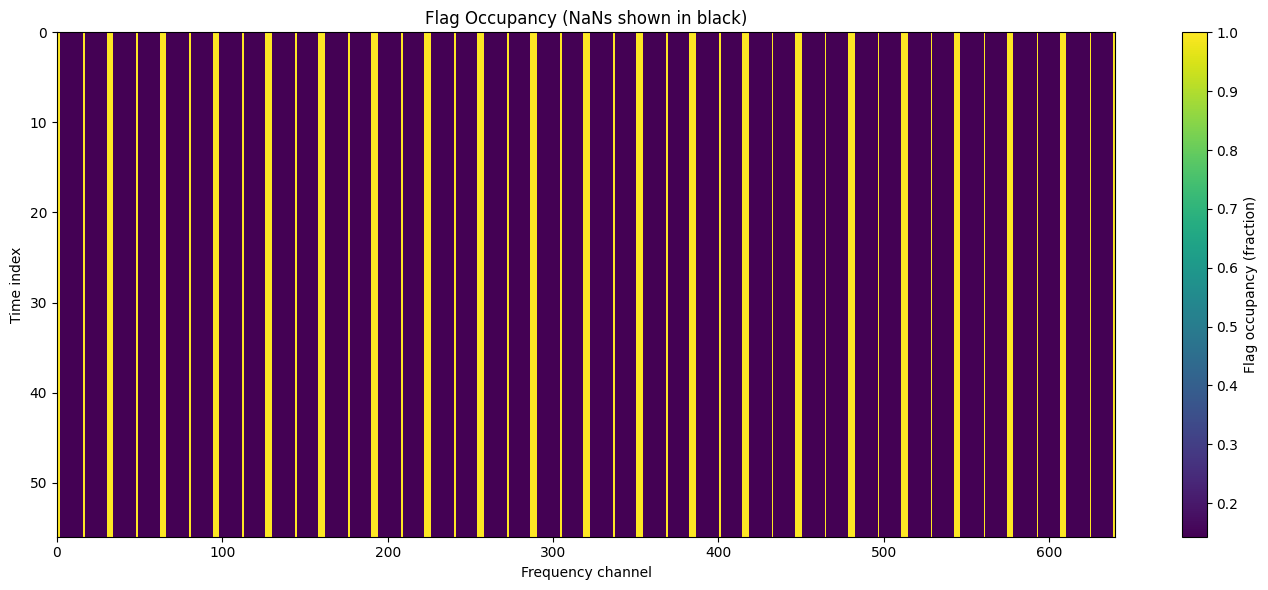

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[0, 640, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel")
plt.ylabel("Time index")
plt.title("Flag Occupancy (NaNs shown in black)")
plt.tight_layout()
plt.show()


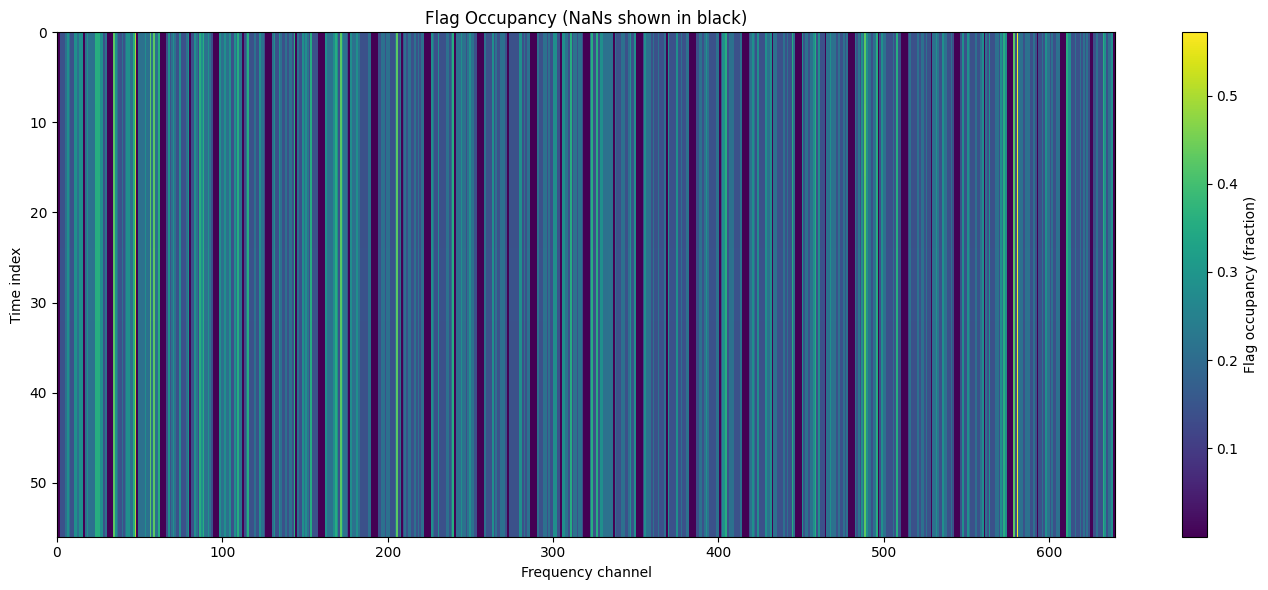

In [22]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create a custom colormap that maps NaN to black
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='black')  # set NaNs to black

# Plot
plt.figure(figsize=(14, 6))
plt.imshow(
    occupancy,
    aspect='auto',
    interpolation='none',
    cmap=cmap,
    extent=[0, 640, 56, 0]
)
plt.colorbar(label="Flag occupancy (fraction)")
plt.xlabel("Frequency channel")
plt.ylabel("Time index")
plt.title("Flag Occupancy (NaNs shown in black)")
plt.tight_layout()
plt.show()

##### with flags

In [21]:
import numpy as np
from astropy.io import fits

POL_ORDER = ['XX', 'XY', 'YX', 'YY']
pol_to_plot = 'XX'  # ← customize this

with_flags = fits.open("/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/uvfits_update/1095451432_w_no_flags059-078_flagged.uvfits")

# Extract metadata
date_unique, unique_id = np.unique(with_flags[0].data['DATE'], return_inverse=True)

# Reshape data
reshaped_no_flags = with_flags[0].data.data.reshape(
    len(np.unique(with_flags[0].data['BASELINE'])),
    len(date_unique),
    with_flags[0].data.data.shape[3],
    with_flags[0].data.data.shape[4],
    with_flags[0].data.data.shape[5]
)

# Extract weights and flags
weights = reshaped_no_flags[..., 2]  # shape: (8128, 56, 640, 4)
flags = weights < 0                  # boolean array of shape (8128, 56, 640, 4)

# Reorder axes: (time, frequency, baseline, polarization)
flags = np.transpose(flags, (1, 2, 0, 3))  # shape: (56, 640, 8128, 4)

# Select polarization
pol_idx = POL_ORDER.index(pol_to_plot)
flags_pol = flags[..., pol_idx]           # shape: (56, 640, 8128)

# Sum over baselines
flag_counts = np.sum(flags_pol, axis=2)   # shape: (56, 640)

# Normalize by total number of baselines
total_possible = flags_pol.shape[2]
occupancy = flag_counts / total_possible  # shape: (56, 640)
occupancy[occupancy == 1.0] = 1e-6